In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

In [4]:
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['LADM', 'LBiceps', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps']

In [2]:
df = pd.read_csv("/home/andres/data/hbmep-processed/J_SHAP/data.csv")

In [8]:
combinations = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl", "rb"))

In [49]:
subjects = df["participant"].unique().tolist()
sizes = ['S', 'B']
directions = ['R-C', 'C-R']
# levels = ['C6-C7', 'C7-C8', 'C7-C6', 'C8-C7']
levels = ['C6-C7', 'C7-C8']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles = model.response
shapes = df.compound_charge_params.unique().tolist()
shapes = [c for c in shapes if c != "80-0-20-400"]

In [62]:
set([p for p in df.compound_position.unique().tolist() if p.split('-')[0] != p.split('-')[1]])

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [39]:
positions = df.compound_position.unique().tolist()
positions = sorted([p for p in positions if ((p.split('-')[0] < p.split('-')[1]) or (p.split('-')[0] > p.split('-')[1]))])
positions = sorted([p for p in positions if (p.split('-')[1] != "" and p.split('-')[0] != "")])
positions = sorted([p for p in positions if (p.split('-')[1][1] != p.split('-')[0][1])])
positions

['C6L-C7L', 'C7L-C6L', 'C7L-C8L', 'C8L-C7L']

In [50]:
arr = []
mask = []

for subject in subjects:
    for direction in directions:
        for level in levels:
            for shape in shapes:
                for muscle in muscles:
                    if direction == 'R-C':
                        f,b = level.split('-')
                        position = f + "L" + "-" + b + "L"
                    else: 
                        f,b = level.split('-')
                        position = b + "L" + "-" + f + "L"
                    key = (subject, position, shape, muscle)
                    if key in combinations.keys():
                        currenta = combinations[key]['a']
                        currenta = currenta.reshape(-1, 1)
                        arr.append(currenta)
                        mask.append(np.full((4000, 1), False))
                    else:
                        arr.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))

arr = np.array(arr)
arr = arr.reshape(len(subjects), len(directions),len(levels), len(shapes), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(directions),len(levels),len(shapes), len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]

In [48]:
arr.shape #subjects, directions, levels, shapes, muscles, posterior samples

(8, 2, 4, 3, 6, 4000)

In [58]:
pvalues = []
mask = []
data = []
means =[]
labels = []

for l_direction_ind, l_direction in enumerate(directions):
    for l_charge_ind, l_charge in enumerate(shapes):
        label = f"{l_direction}: {l_charge}"
        labels.append(label) 
        
        for r_direction_ind, r_direction in enumerate(directions):
            for r_charge_ind, r_charge in enumerate(shapes):
                
                if (l_direction == r_direction) and (l_charge == r_charge):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                
                mask.append(False)

                l_samples = arr[:, l_direction_ind,:, l_charge_ind, ...] # sub, seg, muscle, # posterior_samples
                r_samples = arr[:, r_direction_ind,:, r_charge_ind, ...]
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1, 2)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(6, 6)

mask = np.array(mask)
mask = mask.reshape(6, 6)

data = np.array(data)
data = data.reshape(6, 6)

means = np.array(means)
means = means.reshape(6, 6)

pvalues.shape

(6, 6)

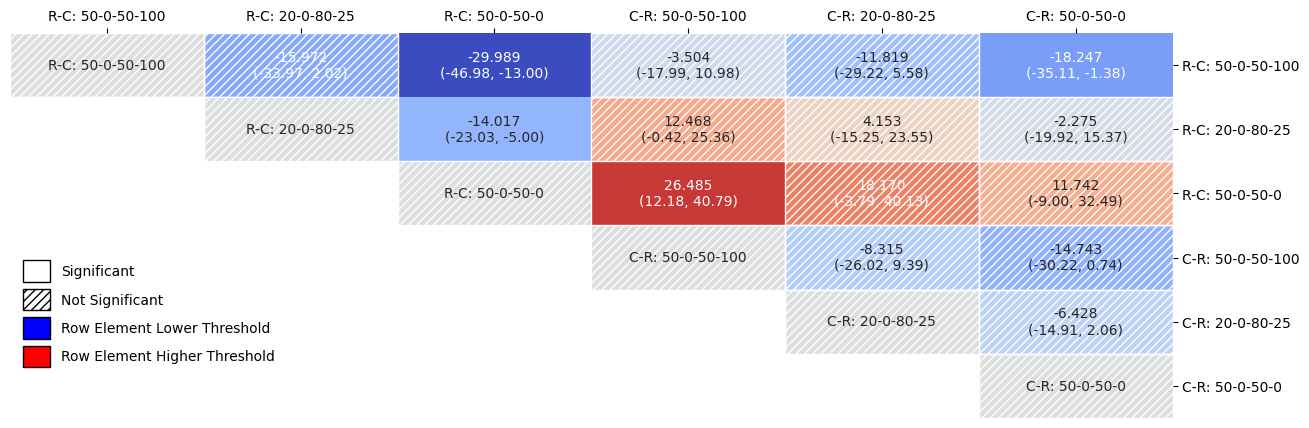

In [61]:
mask2= mask
mask2 = np.tril(np.ones_like(mask2), k=-1)
mask2 = mask2

plt.figure(figsize=(15, 5))
values = means
handles = []
cmap = 'coolwarm'
ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
plt.xticks(rotation=45);
hatch_mask = pvalues > 0.05

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()